In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports

import os
import sys
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface
from maths_utils import weighted_regression


In [2]:
# Import data base
main_dir = '/Users/uriel/disks/meso_shared'
# main_dir = '/home/ulascombes/disks/meso_shared'

project_dir = 'RetinoMaps'
suffix = 'Sac_Pur'

with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
rois = analysis_info['rois']
subjects = analysis_info['subjects']
TR = analysis_info['TR']
rois = analysis_info['rois']
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']
prf_task_name = analysis_info['prf_task_name']
format_ = 'fsnative'

In [3]:
# Plot settings
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]


roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


In [4]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

# Bar plot 

## make Df 

In [20]:
# make all subject categorie proportions  df
rois_area_categorie_df = pd.DataFrame()
for subject in subjects :
    intertask_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(
    main_dir, project_dir, subject, format_)
    data = pd.read_table('{}/{}_intertask-all_derivatives_{}.tsv'.format(intertask_tsv_dir, subject, suffix))
    subject_rois_area_categorie_df = pd.DataFrame()
    for roi in rois : 
        # Compute categorie proportions 
        roi_area = data.loc[data['roi'] == roi].shape[0]
        roi_area_saccade = data.loc[(data['roi'] == roi) & (data['saccade'] == 'saccade')].shape[0]
        roi_area_pursuit = data.loc[(data['roi'] == roi) & (data['pursuit'] == 'pursuit')].shape[0]
        roi_area_vision = data.loc[(data['roi'] == roi) & (data['vision'] == 'vision')].shape[0]
        roi_area_vision_and_pursuit_and_saccade = data.loc[(data['roi'] == roi) & (data['saccade'] == 'saccade') & (data['pursuit'] == 'pursuit') & (data['vision'] == 'vision'), 'vert_area'].shape[0]

        percent_saccade = ((roi_area_saccade * 100)/roi_area)
        percent_pursuit = ((roi_area_pursuit * 100)/roi_area)
        percent_vision = ((roi_area_vision * 100)/roi_area)
        percent_vision_and_pursuit_and_saccade = ((roi_area_vision_and_pursuit_and_saccade * 100)/roi_area)

        roi_area_categorie_df = pd.DataFrame({
                'subject':[subject],
                'roi': [roi],
                'saccade': [percent_saccade],
                'pursuit': [percent_pursuit],
                'vision': [percent_vision],
                'all': [percent_vision_and_pursuit_and_saccade]})


        subject_rois_area_categorie_df = pd.concat([subject_rois_area_categorie_df, roi_area_categorie_df], ignore_index=True)
    
    rois_area_categorie_df = pd.concat([rois_area_categorie_df, subject_rois_area_categorie_df], ignore_index=True)




In [21]:
# make group df 
median_df = rois_area_categorie_df.groupby(['roi'], sort=False).median(numeric_only=True).reset_index()
ci_low_df = rois_area_categorie_df.groupby(['roi'], sort=False).quantile(0.025, numeric_only=True).reset_index()
ci_high_df = rois_area_categorie_df.groupby(['roi'], sort=False).quantile(0.975, numeric_only=True).reset_index()

median_df = median_df.melt(id_vars=['roi'], 
                          value_vars=['saccade', 'pursuit', 'vision', 'all'],
                          var_name='categorie', 
                          value_name='median')

ci_low_df = ci_low_df.melt(id_vars=['roi'], 
                          value_vars=['saccade', 'pursuit', 'vision', 'all'],
                          var_name='categorie', 
                          value_name='ci_low')

ci_high_df = ci_high_df.melt(id_vars=['roi'], 
                          value_vars=['saccade', 'pursuit', 'vision', 'all'],
                          var_name='categorie', 
                          value_name='ci_high')


group_rois_area_categorie_df = pd.concat([median_df, ci_low_df.drop(columns=['roi', 'categorie']), ci_high_df.drop(columns=['roi', 'categorie'])], axis=1).reset_index(drop=True)


## make plot

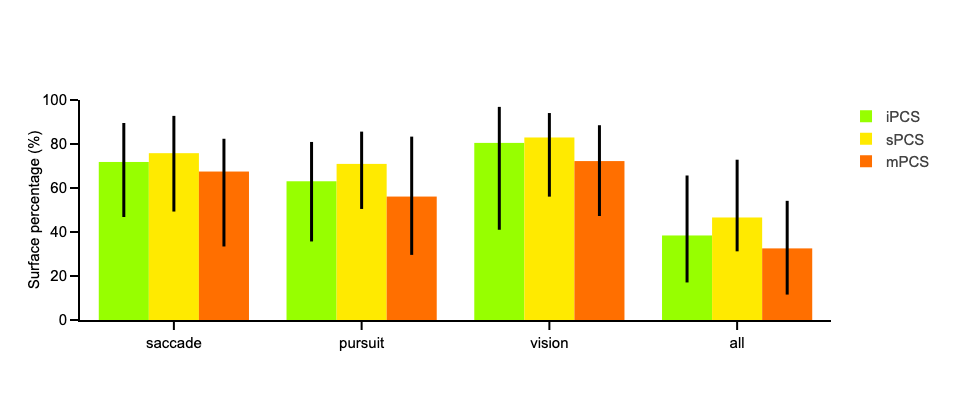

In [22]:
sub_rois =  ['iPCS', 'sPCS', 'mPCS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group', 
                  height=400, 
                  width=800)

fig.show()
fig.write_image("/Users/uriel/Downloads/Surface_percentage_4.pdf".format(subject))

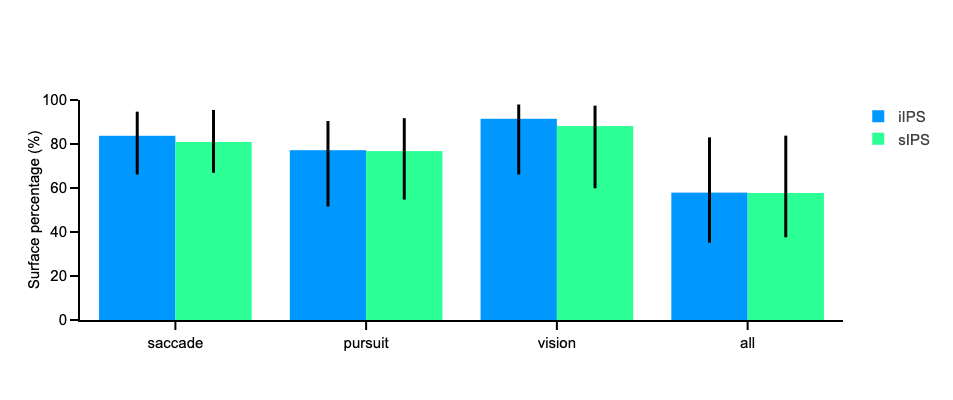

In [23]:
sub_rois =  ['iIPS', 'sIPS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group',
                  height=400, 
                  width=800)

fig.show()
fig.write_image("/Users/uriel/Downloads/Surface_percentage_3.pdf".format(subject))

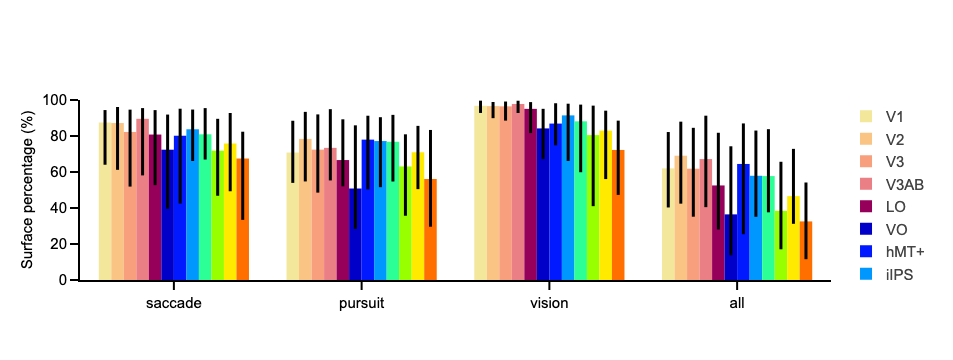

In [24]:
sub_rois =  ['V1', 'V2', 'V3', 'V3AB', 'LO', 'VO', 'hMT+', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group')

fig.show()
fig.write_image("/Users/uriel/Downloads/Surface_percentage_5.pdf".format(subject))

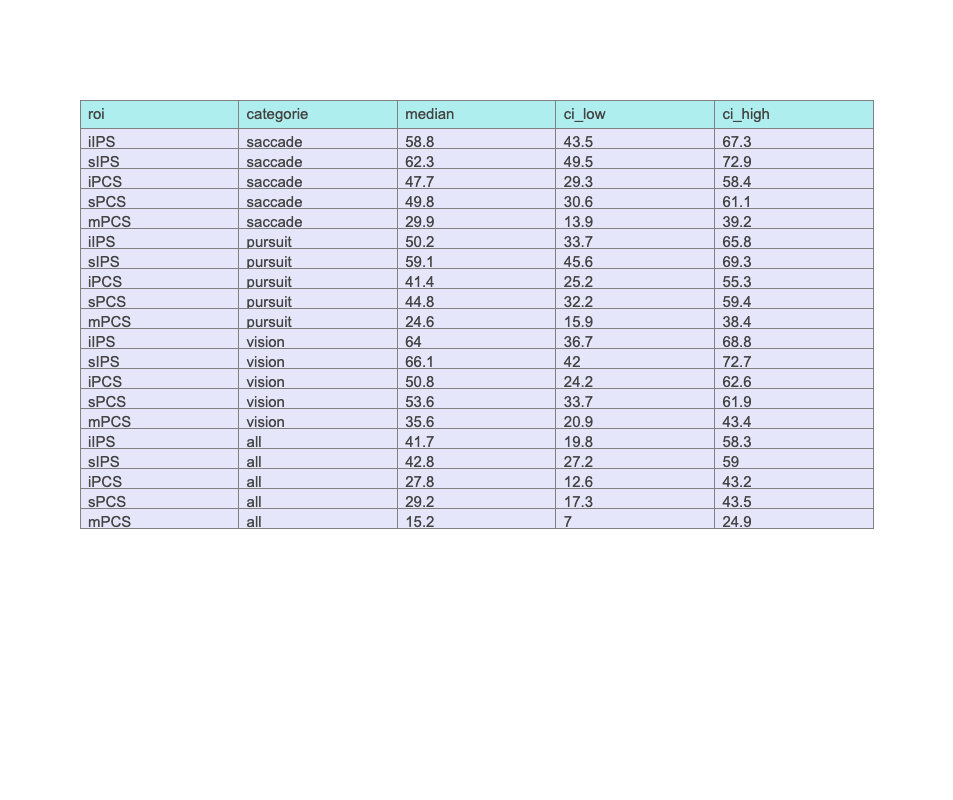

In [53]:
sub_rois =  ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']


df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi'].isin(sub_rois)]


fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_roi.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_roi[col].round(1) for col in df_roi.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=800, 
                  width=800)
fig.write_image("/Users/uriel/Downloads/Surface_percentage_table.pdf".format(subject))
fig.show()

# Contralaterlity

In [20]:
subject = 'group'
format_ = '170k'
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
data_contralaterality = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_contralaterality_{}.tsv'.format(intertask_all_tsv_dir, subject, suffix))

In [52]:
data_contralaterality[['contralaterality_prct', 'ci_down', 'ci_up']] = data_contralaterality[['contralaterality_prct', 'ci_down', 'ci_up']] * 100


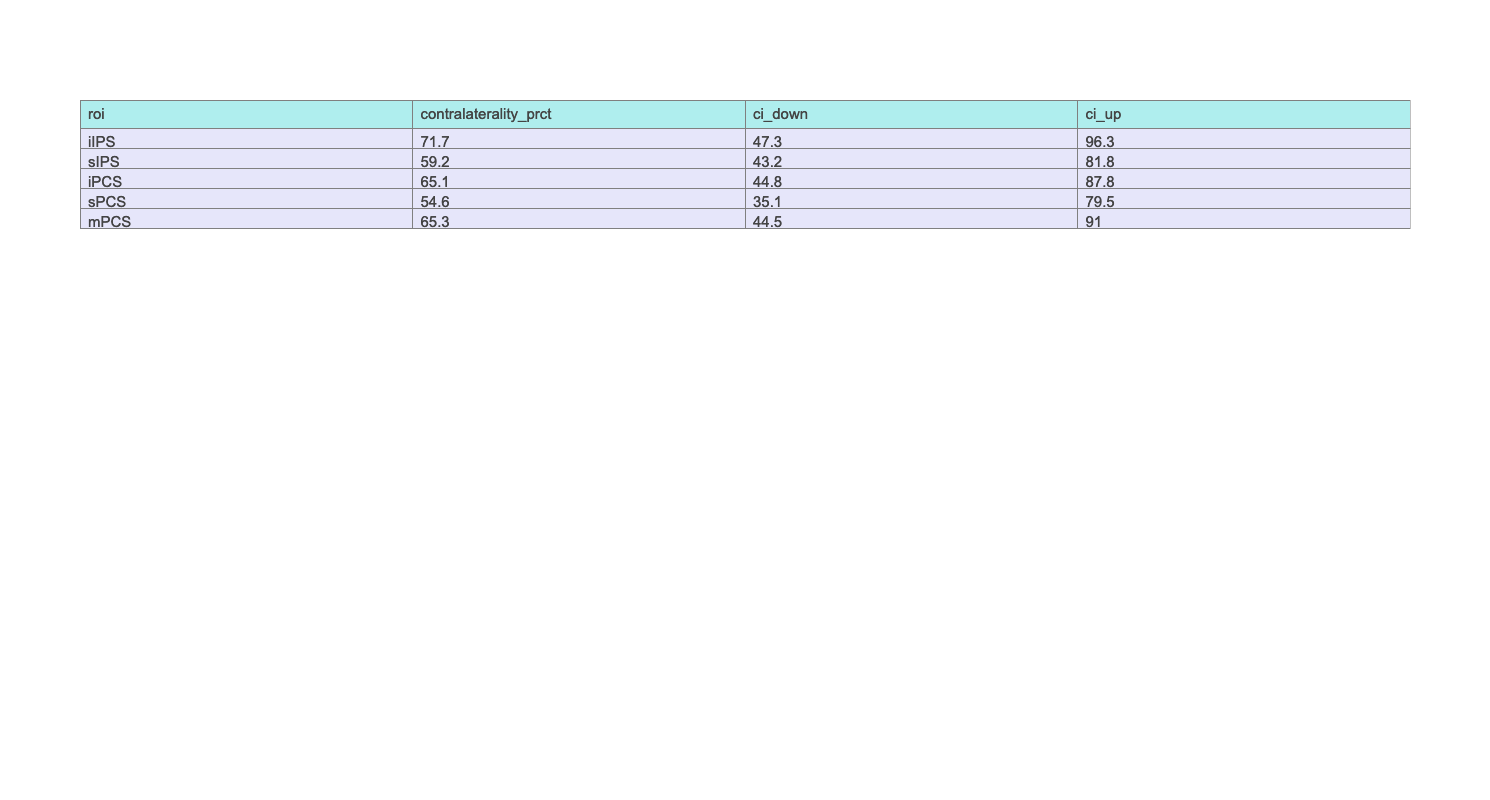

In [56]:
sub_rois =  ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']


df_roi = data_contralaterality.loc[data_contralaterality['roi'].isin(sub_rois)]


fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_roi.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_roi[col].round(1) for col in df_roi.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=800, 
                  width=800)
fig.write_image("/Users/uriel/Downloads/contralaterality_table.pdf".format(subject))
fig.show()

# pRF plots

## Figures settings

In [1]:
plot_groups = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]
fig_width = 1440
max_ecc = 15

# tresholds
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]


colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]

roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}

## Ecc size

In [80]:
def prf_ecc_size_plot(df_ecc_size, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for linear relationship between eccentricity and size

    Parameters
    ----------
    df_ecc_size : A data dataframe
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity 
    
    Returns
    -------
    fig : eccentricy as a function of size plot
    """
    
    from maths_utils import weighted_regression

    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):
            
            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_size.loc[(df_ecc_size.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            size_median = np.array(df.prf_size_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            size_upper_bound = np.array(df.prf_size_bins_ci_upper_bound)
            size_lower_bound = np.array(df.prf_size_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, size_median, r2_median, model='linear')
            slope_upper, intercept_upper = weighted_regression(ecc_median[np.where(~np.isnan(size_upper_bound))], 
                                                               size_upper_bound[~np.isnan(size_upper_bound)], 
                                                               r2_median[np.where(~np.isnan(size_upper_bound))], 
                                                               model='linear')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[np.where(~np.isnan(size_lower_bound))], 
                                                               size_lower_bound[~np.isnan(size_lower_bound)], 
                                                               r2_median[np.where(~np.isnan(size_lower_bound))], 
                                                               model='linear')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = slope * line_x + intercept
            line_upper = slope_upper * line_x + intercept_upper
            line_lower = slope_lower * line_x + intercept_lower

            fig.add_trace(go.Scatter(x=line_x, y=line, mode='lines', name=roi, legendgroup=roi, 
                                      line=dict(color=roi_color, width=3), showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]), 
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=size_median, mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=size_upper_bound - size_median, 
                                                  arrayminus=size_median - size_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                      marker=dict(color=roi_color,
                                                  symbol='square',
                                                  size=8, 
                                                  line=dict(color=roi_color, 
                                                            width=3)), 
                                      showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=max_ecc-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
            
            
        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF size (dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_ecc], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=470, margin_r=470, margin_t=50, margin_b=100)
        


        
    return fig

In [6]:
subject = 'group'
format_ = '170k'
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)

df_ecc_size = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_size_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))


In [12]:
result = stats.linregress(x=df_ecc_size.prf_ecc_bins,
                          y=df_ecc_size.prf_size_bins_median,
                          alternative='two-sided')

In [24]:
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']
fig = prf_ecc_size_plot(df_ecc_size=df_ecc_size, fig_width=fig_width, 
                        fig_height=400, rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc)

fig.show()
fig.write_image("/Users/uriel/Downloads/{}_ecc_size.pdf".format(subject))

KeyError: 0

In [23]:
df_stats = pd.DataFrame()
# for subject in subjects :
for subject in subjects :
    intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
    tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, project_dir, subject, format_)

    df_ecc_size = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_size_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))
    # for roi in rois: 
    for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']: 
        df_stats_roi = pd.DataFrame()
        # Get data
        df_ecc_size_roi = df_ecc_size.loc[(df_ecc_size.roi == roi)]
        
        ecc_median = np.array(df_ecc_size_roi.prf_ecc_bins)
        size_median = np.array(df_ecc_size_roi.prf_size_bins_median)
        r2_median = np.array(df_ecc_size_roi.prf_loo_r2_bins_median)


        # Creat model 
        slope, intercept = weighted_regression(ecc_median, size_median, r2_median, model='linear')
        
        # Load data
        df_pRF = pd.read_table('{}/{}_css-all_derivatives.tsv'.format(tsv_dir,subject))
        
        # Threshold data (replace by nan)
        if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
        elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
        df_pRF.loc[(df_pRF.amplitude < amplitude_threshold) |
                 (df_pRF.prf_ecc < ecc_threshold[0]) | (df_pRF.prf_ecc > ecc_threshold[1]) |
                 (df_pRF.prf_size < size_threshold[0]) | (df_pRF.prf_size > size_threshold[1]) | 
                 (df_pRF.prf_n < n_threshold[0]) | (df_pRF.prf_n > n_threshold[1]) | 
                 (df_pRF.prf_loo_r2 < rsqr_threshold) |
                 (df_pRF[stats_col] > stats_threshold)] = np.nan
        df_pRF = df_pRF.dropna()
        
        
        df_pRF_roi = df_pRF.loc[(df_pRF.roi == roi)]
        
        pred_size_roi = df_pRF_roi.prf_ecc * slope + intercept 
        
        # mask for nan
        mask = ~df_pRF_roi.prf_size.isna() & ~pred_size_roi.isna()

        # linear regression between model and data 
        results = stats.linregress(x=pred_size_roi[mask], y=df_pRF_roi.prf_size[mask], alternative='greater')
        
        df_stats_roi['subject'] = [subject]
        df_stats_roi['roi'] = [roi]
        df_stats_roi['rvalue'] = [results.rvalue]
        df_stats_roi['pvalue'] = [results.pvalue]
        
        df_stats = pd.concat([df_stats, df_stats_roi])
        

In [24]:
fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_stats.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_stats[col].round(3) for col in df_stats.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=2500, 
                  width=1200)
fig.write_image("/Users/uriel/Downloads/ecc_size_stats2.pdf".format(subject))
# fig.show()


In [62]:
print('ecc / size relation signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'] : 
    df_stats_roi_significant = df_stats.loc[(df_stats['roi']==roi)&(df_stats['pvalue'] < 0.01)]
    
    print('{}'. format(roi))
    print('all p-value inferior to {}'.format(df_stats_roi_significant['pvalue'].max()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / size relation signifante subjects
iIPS
all p-value inferior to 1.141755555904516e-16
r interval : 0.21 0.68
sIPS
all p-value inferior to 1.0354895733876582e-46
r interval : 0.3 0.7
iPCS
all p-value inferior to 1.0943433387775678e-18
r interval : 0.25 0.75
sPCS
all p-value inferior to 3.1273594774989264e-26
r interval : 0.26 0.71
mPCS
all p-value inferior to 1.4809249264991066e-15
r interval : 0.33 0.73


In [80]:
print('ecc / size relation non signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']:
    df_stats_roi_significant = df_stats.loc[(df_stats['roi'] == roi) & (df_stats['pvalue'] > 0.01)]
    
    if df_stats_roi_significant.empty:
        print('{}: no subject non significant'.format(roi))
        continue  # Passer à l'itération suivante si df_stats_roi_significant est vide
    
    print('{}'.format(roi))
    print('{} subject(s) is / are not significative : ({})'.format(df_stats_roi_significant['subject'].shape[0] , df_stats_roi_significant['subject'].values))
    print('all p-value superior to {}'.format(df_stats_roi_significant['pvalue'].min()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / size relation non signifante subjects
iIPS
1 subject(s) is / are not significative : (['sub-11'])
all p-value superior to 0.2547203629260645
r interval : 0.01 0.01
sIPS
1 subject(s) is / are not significative : (['sub-11'])
all p-value superior to 0.0204775472614259
r interval : 0.04 0.04
iPCS: no subject non significant
sPCS
1 subject(s) is / are not significative : (['sub-11'])
all p-value superior to 0.5387522755454627
r interval : -0.0 -0.0
mPCS: no subject non significant


## Ecc pRF CM

In [32]:
def prf_ecc_pcm_plot(df_ecc_pcm, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """

    from maths_utils import weighted_regression
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            pcm_median = np.array(df.prf_pcm_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_median[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_median[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_median[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=pcm_median, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_median, 
                                                  arrayminus=pcm_median - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=12, y=(20)-j*2, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
        

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, 15], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=470, margin_r=470, margin_t=50, margin_b=100)
        
    return fig

In [34]:
df_ecc_pcm = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_pcm_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))

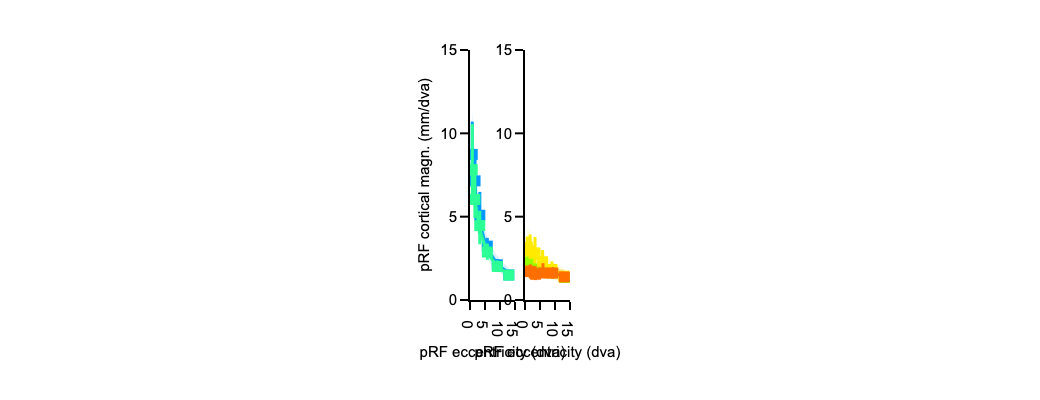

In [36]:
fig2 = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=fig_width, fig_height=400, 
                        rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc)

fig2.show()
fig2.write_image("/Users/uriel/Downloads/{}_ecc_pcm.pdf".format(subject))

In [64]:
df_stats_ecc_pcm = pd.DataFrame()
for subject in subjects :
# for subject in ['sub-07'] :
    intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
    tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, project_dir, subject, format_)

    df_ecc_pcm = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_pcm_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))
    # for roi in rois: 
    for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']: 
    # for roi in ['sIPS']: 
        df_stats_ecc_pcm_roi = pd.DataFrame()
        # Get data
        df_ecc_pcm_roi = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
        
        ecc_median = np.array(df_ecc_pcm_roi.prf_ecc_bins)
        pcm_median = np.array(df_ecc_pcm_roi.prf_pcm_bins_median)
        r2_median = np.array(df_ecc_pcm_roi.prf_loo_r2_bins_median)


        # Creat model 
        slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
        
        # Load data
        df_pRF = pd.read_table('{}/{}_css-all_derivatives.tsv'.format(tsv_dir,subject))
        
        # Threshold data (replace by nan)
        if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
        elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
        df_pRF.loc[(df_pRF.amplitude < amplitude_threshold) |
                 (df_pRF.prf_ecc < ecc_threshold[0]) | (df_pRF.prf_ecc > ecc_threshold[1]) |
                 (df_pRF.prf_size < size_threshold[0]) | (df_pRF.prf_size > size_threshold[1]) | 
                 (df_pRF.prf_n < n_threshold[0]) | (df_pRF.prf_n > n_threshold[1]) | 
                 (df_pRF.prf_loo_r2 < rsqr_threshold) |
                 (df_pRF[stats_col] > stats_threshold)] = np.nan
        df_pRF = df_pRF.dropna()
        
        
        df_pRF_roi = df_pRF.loc[(df_pRF.roi == roi)]
        
        pred_pcm_roi = 1 / (df_pRF_roi.prf_ecc * slope + intercept) 
        
        # mask for nan
        mask = ~df_pRF_roi.pcm_median.isna() & ~pred_pcm_roi.isna()

        # linear regression between model and data 
        results = stats.linregress(x=pred_pcm_roi[mask], y=df_pRF_roi.pcm_median[mask], alternative='greater')
        
        df_stats_ecc_pcm_roi['subject'] = [subject]
        df_stats_ecc_pcm_roi['roi'] = [roi]
        df_stats_ecc_pcm_roi['rvalue'] = [results.rvalue]
        df_stats_ecc_pcm_roi['pvalue'] = [results.pvalue]
        
        df_stats_ecc_pcm = pd.concat([df_stats_ecc_pcm, df_stats_ecc_pcm_roi])
        

In [81]:
print('ecc / pcm relation signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'] : 
    df_stats_roi_significant = df_stats_ecc_pcm.loc[(df_stats['roi']==roi)&(df_stats_ecc_pcm['pvalue'] < 0.01)]
    
    print('{}'. format(roi))
    print('all p-value inferior to {}'.format(df_stats_roi_significant['pvalue'].max()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / pcm relation signifante subjects
iIPS
all p-value inferior to 2.9033579296071657e-10
r interval : 0.14 0.85
sIPS
all p-value inferior to 1.155012395099104e-68
r interval : 0.47 0.84
iPCS
all p-value inferior to 0.007951947089380643
r interval : 0.09 0.73
sPCS
all p-value inferior to 6.834237191079528e-22
r interval : 0.24 0.84
mPCS
all p-value inferior to 0.008253033586031232
r interval : 0.08 0.8


In [82]:
print('ecc / pcm relation non signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']:
    df_stats_roi_significant = df_stats_ecc_pcm.loc[(df_stats['roi'] == roi) & (df_stats_ecc_pcm['pvalue'] > 0.01)]
    
    if df_stats_roi_significant.empty:
        print('{}: no subject non significant'.format(roi))
        continue  # Passer à l'itération suivante si df_stats_roi_significant est vide
    
    print('{}'.format(roi))
    print('{} subject(s) is / are not significative : ({})'.format(df_stats_roi_significant['subject'].shape[0] , df_stats_roi_significant['subject'].values))
    print('all p-value superior to {}'.format(df_stats_roi_significant['pvalue'].min()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / pcm relation non signifante subjects
iIPS: no subject non significant
sIPS
2 subject(s) is / are not significative : (['sub-02' 'sub-07'])
all p-value superior to 0.24951673913945166
r interval : -0.14 0.01
iPCS
5 subject(s) is / are not significative : (['sub-01' 'sub-07' 'sub-09' 'sub-22' 'sub-25'])
all p-value superior to 0.11528762556608933
r interval : -0.38 0.04
sPCS
2 subject(s) is / are not significative : (['sub-07' 'sub-23'])
all p-value superior to 0.992587301621508
r interval : -0.21 -0.05
mPCS
7 subject(s) is / are not significative : (['sub-03' 'sub-04' 'sub-06' 'sub-09' 'sub-20' 'sub-23' 'sub-25'])
all p-value superior to 0.015832897459077816
r interval : -0.39 0.09


In [22]:
fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_stats_ecc_pcm.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_stats_ecc_pcm[col].round(3) for col in df_stats_ecc_pcm.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=2500, 
                  width=1200)
fig.write_image("/Users/uriel/Downloads/ecc_pcm_stats2.pdf".format(subject))
# fig.show()

# Pycortex maps 

##  intertask

In [26]:
subject = 'sub-03'
pycortex_subject = 'sub-170k'
format_ = '170k'
extension = 'dtseries.nii'
prf_task_name = analysis_info['prf_task_name']
alpha_range = analysis_info["alpha_range"]
group_tasks = analysis_info['task_intertask']
flatmaps_dir = '/Users/uriel/Desktop/flatmaps/'

# Maps settings
all_idx, pur_idx, sac_idx, pur_sac_idx, prf_idx, prf_pur_idx, prf_sac_idx, \
        prf_pur_sac_idx = 0,1,2,3,4,5,6,7

slope_idx, intercept_idx, rvalue_idx, pvalue_idx, stderr_idx, \
    trs_idx, corr_pvalue_5pt_idx, corr_pvalue_1pt_idx = 0, 1, 2, 3, 4, 5, 6, 7

# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Define/create colormap
colormap_name = 'viridis'
colormap_dict = {'n/a': (255, 255, 255),
                 'Pursuit':  (227, 119, 194),
                 'Saccade': (140, 86, 75),
                 'Pursuit_and_Saccade': (148, 103, 189),
                 'Vision': (214, 39, 40),
                 'Vision_and_Pursuit': (44, 160, 44), 
                 'Vision_and_Saccade': (255, 127, 14),
                 'Vision_and_Pursuit_and_Saccade': (31, 119, 180)}
# create_colormap(cortex_dir=cortex_dir, 
#                 colormap_name=colormap_name, 
#                 colormap_dict=colormap_dict)

suffix = 'Sac_Pur'
sac_task = 'SacVELoc'
pur_task = 'PurVELoc'

# Define directories and fn
intertask_dir = "{}/{}/derivatives/pp_data/{}/{}/intertask".format(
    main_dir, project_dir, subject,format_)
prf_stats_dir = "{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives".format(
    main_dir, project_dir, subject,format_)
glm_stats_dir = "{}/{}/derivatives/pp_data/{}/{}/glm/glm_derivatives".format(
    main_dir, project_dir,  subject,format_)

stats_avg_fn = '{}/{}_intertask_{}.dtseries.nii'.format(
    intertask_dir, subject, suffix)
prf_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-stats_loo-median.dtseries.nii'.format(
    prf_stats_dir, subject, prf_task_name)
sac_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_glm-stats_loo-median.dtseries.nii'.format(
    glm_stats_dir, subject, sac_task)
pur_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_glm-stats_loo-median.dtseries.nii'.format(
    glm_stats_dir, subject, pur_task)

#  Load data
results_stats = load_surface_pycortex(brain_fn=stats_avg_fn)
intertask_mat = results_stats['data_concat']

results_prf = load_surface_pycortex(brain_fn=prf_stats_avg_fn)
prf_mat = results_prf['data_concat']

results_sac = load_surface_pycortex(brain_fn=sac_stats_avg_fn)
sac_mat = results_sac['data_concat']

results_pur = load_surface_pycortex(brain_fn=pur_stats_avg_fn)
pur_mat = results_pur['data_concat']

if subject == 'sub-170k': save_svg = save_svg
else: save_svg = False


# Compute R2 from R
prf_mat[rvalue_idx,:] =  prf_mat[rvalue_idx,:]**2
sac_mat[rvalue_idx,:] = sac_mat[rvalue_idx,:]**2
pur_mat[rvalue_idx,:] = pur_mat[rvalue_idx,:]**2

# threshold data
# pRF
prf_mat_corrected = copy.copy(prf_mat)
prf_mat_corrected_th = prf_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = prf_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = prf_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
prf_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

# SacLoc        
sac_mat_corrected = copy.copy(sac_mat)
sac_mat_corrected_th = sac_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = sac_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = sac_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
sac_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

# PurLoc        
pur_mat_corrected = copy.copy(pur_mat)
pur_mat_corrected_th = pur_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = pur_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = pur_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
pur_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

#  Creat R2 for the all flatmap
rsq_all = np.zeros((intertask_mat[all_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[all_idx,...]):
    if categorie == 1: rsq_all[vert] = pur_mat_corrected[rvalue_idx,vert]

    elif categorie == 2: rsq_all[vert] = sac_mat_corrected[rvalue_idx,vert]

    elif categorie == 3: rsq_all[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                     sac_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 4: rsq_all[vert] = prf_mat_corrected[rvalue_idx,vert]

    elif categorie == 5: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                     pur_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 6: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                     sac_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 7: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                      sac_mat_corrected[rvalue_idx,vert], 
                                                      pur_mat_corrected[rvalue_idx,vert]], 
                                                    axis=0)

#  Creat R2 for the pur_sac flatmap       
rsq_pur_sac = np.zeros((intertask_mat[pur_sac_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[pur_sac_idx,...]):
    if categorie == 3: rsq_pur_sac[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_pur flatmap               
rsq_prf_pur = np.zeros((intertask_mat[prf_pur_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[prf_pur_idx,...]):
    if categorie == 5: rsq_prf_pur[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_sac flatmap               
rsq_prf_sac = np.zeros((intertask_mat[prf_sac_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[prf_sac_idx,...]):
    if categorie == 6: rsq_prf_sac[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_pur_sac flatmap               
rsq_prf_pur_sac = np.zeros((intertask_mat[all_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[all_idx,...]):
    if categorie == 7: rsq_prf_pur_sac[vert] = np.nanmean([prf_mat[rvalue_idx,vert], 
                                                           sac_mat_corrected[rvalue_idx,vert], 
                                                           pur_mat_corrected[rvalue_idx,vert]], 
                                                          axis=0)

# Create flatmaps  
print('Creating flatmaps...')
maps_names = []      

# get roi mask 
rois_dic = get_rois(subject='sub-12', return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']


masks = {'frontal_mask':frontal_mask}
# masks = {'parietal_mask':parietal_mask}

for mask in masks.keys():
    rois_mask = masks[mask]
    
#     #  Creat the all 
#     alpha_all = (rsq_all - alpha_range[0])/(alpha_range[1]-alpha_range[0])
#     alpha_all[alpha_all>1]=1
#     alpha_all[~rois_mask] = 0


#     intertask_data_all = intertask_mat[all_idx,...]
#     alpha_all[intertask_data_all == 0] = 0
#     param_all = {'data': intertask_data_all, 
#                  'cmap': colormap_name, 
#                  'alpha': alpha_all, 
#                  'vmin': 0, 
#                  'vmax': 7, 
#                  'cbar': 'discrete_personalized', 
#                  'cmap_steps': len(colormap_dict),
#                  'cmap_dict': colormap_dict,
#                  'cortex_type': 'VertexRGB', 
#                  'description': 'intertask map', 
#                  'curv_brightness': 0.5, 
#                  'curv_contrast': 0.25, 
#                  'add_roi': save_svg, 
#                  'cbar_label': '', 
#                  'with_labels': True}
#     maps_names.append('all')

    #  Creat the vision_and_pursuit_and_saccade flatmap
    alpha_prf_pur_sac = (rsq_prf_pur_sac - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_prf_pur_sac[alpha_prf_pur_sac>1]=1
    alpha_prf_pur_sac[~rois_mask] = 0


    intertask_data_prf_pur_sac = intertask_mat[prf_pur_sac_idx,...]
    alpha_prf_pur_sac[intertask_data_prf_pur_sac == 0] = 0
    param_vision_and_pursuit_and_saccade = {'data': rsq_prf_pur_sac, 
                                            'cmap': colormap_name, 
                                            'alpha': alpha_prf_pur_sac, 
                                            'vmin': 0, 
                                            'vmax': 0.4, 
#                                             'cbar': 'discrete_personalized', 
                                            'cmap_steps': len(colormap_dict), 
                                            'cmap_dict': colormap_dict,
                                            'cortex_type': 'VertexRGB', 
                                            'description': 'intertask map', 
                                            'curv_brightness': 1, 
                                            'curv_contrast': 0.25, 
                                            'add_roi': save_svg, 
                                            'cbar_label': '',  
                                            'with_labels': True}
    maps_names.append('vision_and_pursuit_and_saccade')
    
    #  Creat the pursuit flatmap
    rsq_pur = pur_mat_corrected[rvalue_idx, :]


    alpha_pur = (rsq_pur - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_pur[alpha_pur>1]=1
    # alpha_pur[~rois_mask] = 0



    intertask_data_pur = intertask_mat[pur_idx,...]
    alpha_pur[intertask_data_pur == 0] = 0
    param_pursuit = {'data': rsq_pur, 
                     'cmap': colormap_name, 
                     'alpha': alpha_pur, 
                     'vmin': 0, 
                     'vmax': 0.4, 
#                      'cbar': 'discrete_personalized', 
                     'cmap_steps': len(colormap_dict),
                     'cmap_dict': colormap_dict,
                     'cortex_type': 'VertexRGB', 
                     'description': 'intertask map',
                     'curv_brightness': 1, 
                     'curv_contrast': 0.25, 
                     'add_roi': save_svg,
                     'cbar_label': '', 
                     'with_labels': True}
    maps_names.append('pursuit')

    #  Creat the saccade flatmap
    rsq_sac = sac_mat_corrected[rvalue_idx, :]
    alpha_sac = (rsq_sac - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_sac[alpha_sac>1]=1
    # alpha_sac[~rois_mask] = 0


    intertask_data_sac = intertask_mat[sac_idx,...]
    alpha_sac[intertask_data_sac == 0] = 0
    param_saccade = {'data': rsq_sac, 
                     'cmap': colormap_name, 
                     'alpha': alpha_sac, 
                     'vmin': 0, 
                     'vmax': 0.4, 
#                      'cbar': 'discrete_personalized', 
                     'cmap_steps': len(colormap_dict),
                     'cmap_dict': colormap_dict,
                     'cortex_type': 'VertexRGB', 
                     'description': 'intertask map',
                     'curv_brightness': 1, 
                     'curv_contrast': 0.25, 
                     'add_roi': save_svg,
                     'cbar_label': '', 
                     'with_labels': True}
    maps_names.append('saccade')
    
    #  Creat the vision flatmap
    rsq_prf = prf_mat_corrected[rvalue_idx, :].astype(np.float64)
    alpha_prf = (rsq_prf - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_prf[alpha_prf>1]=1
    # alpha_prf[~rois_mask] = 0


    intertask_data_prf = intertask_mat[prf_idx,...]
    alpha_prf[intertask_data_prf == 0] = 0
    param_vision = {'data': rsq_prf, 
                    'cmap': colormap_name, 
                    'alpha': alpha_prf, 
                    'vmin': 0, 
                    'vmax': 0.4, 
#                     'cbar': 'discrete_personalized', 
                    'cmap_steps': len(colormap_dict),
                    'cmap_dict': colormap_dict,
                    'cortex_type': 'VertexRGB', 
                    'description': 'intertask map',
                    'curv_brightness': 1, 
                    'curv_contrast': 0.25, 
                    'add_roi': save_svg,
                    'cbar_label': '',
                    'with_labels': True}
    maps_names.append('vision')

    # draw flatmaps
    volumes = {}
    for maps_name in maps_names:

        # create flatmap
        roi_name = '{}'.format(maps_name)
        roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
        print(roi_name)
        exec('param_{}.update(roi_param)'.format(maps_name))
        exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name = maps_name))
        exec("plt.savefig('{}/{}_{}_{}_{}.pdf')".format(flatmaps_dir, subject, maps_name, suffix, mask))
        plt.close()





FileNotFoundError: No such file or no access: '/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-03/170k/intertask/sub-03_intertask_Sac_Pur.dtseries.nii'

In [12]:
rsq_prf.max()

0.856955378019908

## pRF

In [6]:
subject = 'sub-03'
pycortex_subject = 'sub-170k'
format_ = '170k'
extension = 'dtseries.nii'
flatmaps_dir = '/Users/uriel/Desktop/flatmaps/'


prf_task_name = analysis_info['prf_task_name']
maps_names_css = analysis_info['maps_names_css']
maps_names_pcm = analysis_info['maps_names_pcm']
maps_names_css_stats = analysis_info['maps_names_css_stats']



rois_dic = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']

parietal_frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']
save_svg = False
# masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}
# masks = {'parietal_mask':parietal_mask}
masks = {'frontal_mask':frontal_mask}


for mask in masks.keys():
    rois_mask = masks[mask]
    all_idx = 0
    # Maps settings 
    for idx, col_name in enumerate(maps_names_css + maps_names_css_stats + maps_names_pcm):
        exec("{}_idx = idx".format(col_name))

    cmap_polar, cmap_uni, cmap_ecc_size = 'hsv', 'Reds', 'Spectral'
    col_offset = 1.0/14.0
    cmap_steps = 255

    # plot scales
    pcm_scale = [0, 10]
    size_scale = [0, 10]
    ecc_scale = [0, 10]
    rsq_scale = [0, 1]
    n_scale = [0, 2]


    # Define directories and fn
    prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
    prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
    intertask_dir = "{}/{}/derivatives/pp_data/{}/{}/intertask".format(
    main_dir, project_dir, subject,format_)

    # Derivatives
    deriv_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-deriv_css_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    deriv_results = load_surface_pycortex(brain_fn=deriv_median_fn)
    deriv_mat = deriv_results['data_concat']

    # Stats
    stats_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-stats_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    stats_results = load_surface_pycortex(brain_fn=stats_median_fn)
    stats_mat = stats_results['data_concat']

    # pRF CM
    pcm_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-pcm_css_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    pcm_results = load_surface_pycortex(brain_fn=pcm_median_fn)
    pcm_mat = pcm_results['data_concat']

    # intertask results 
    stats_avg_fn = '{}/{}_intertask_{}.dtseries.nii'.format(
    intertask_dir, subject, suffix)
    results_stats = load_surface_pycortex(brain_fn=stats_avg_fn)
    intertask_mat = results_stats['data_concat']
    mask_intertask = intertask_mat[all_idx, :] == 7

    # Combine mat
    all_deriv_mat = np.concatenate((deriv_mat, stats_mat, pcm_mat))

    # Threshold mat
    all_deriv_mat_th = all_deriv_mat
    amp_down = all_deriv_mat_th[amplitude_idx,...] > 0
    rsq_down = all_deriv_mat_th[prf_loo_r2_idx,...] >= analysis_info['rsqr_th']
    size_th_down = all_deriv_mat_th[prf_size_idx,...] >= analysis_info['size_th'][0]
    size_th_up = all_deriv_mat_th[prf_size_idx,...] <= analysis_info['size_th'][1]
    ecc_th_down = all_deriv_mat_th[prf_ecc_idx,...] >= analysis_info['ecc_th'][0]
    ecc_th_up = all_deriv_mat_th[prf_ecc_idx,...] <= analysis_info['ecc_th'][1]
    n_th_down = all_deriv_mat_th[prf_n_idx,...] >= analysis_info['n_th'][0]
    n_th_up = all_deriv_mat_th[prf_n_idx,...] <= analysis_info['n_th'][1]
    if analysis_info['stats_th'] == 0.05: stats_th_down = all_deriv_mat_th[corr_pvalue_5pt_idx,...] <= 0.05
    elif analysis_info['stats_th'] == 0.01: stats_th_down = all_deriv_mat_th[corr_pvalue_1pt_idx,...] <= 0.01
    all_th = np.array((amp_down,
                       rsq_down,
                       size_th_down,size_th_up, 
                       ecc_th_down, ecc_th_up,
                       n_th_down, n_th_up,
                       stats_th_down
                      )) 
    all_deriv_mat[prf_loo_r2_idx, np.logical_and.reduce(all_th)==False]=0 # put this to zero to not plot it

    # Create flatmaps
    maps_names = []

    # Loo r-square and alpha
    loo_rsq_data = all_deriv_mat[prf_loo_r2_idx,...]
    alpha = loo_rsq_data
    alpha_range = analysis_info["alpha_range"]
    alpha = (alpha - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
    alpha[alpha>1]=1

    # put alpha to 0 outside non interest roi 
    alpha[~rois_mask] = 0
    alpha[~mask_intertask] = 0

    # param_loo_rsq = {'data': loo_rsq_data, 
    #                  'cmap': cmap_uni, 
    #                  'alpha': alpha, 
    #                  'vmin': rsq_scale[0], 
    #                  'vmax': rsq_scale[1], 
    #                  'cbar': 'discrete', 
    #                  'cortex_type': 'VertexRGB',
    #                  'description': 'CSS pRF LOO R2',
    #                  'curv_brightness':1,
    #                  'curv_contrast': 0.1,
    #                  'add_roi': save_svg,
    #                  'cbar_label': 'pRF LOO R2', 
    #                  'with_labels': True}
    # maps_names.append('loo_rsq')

#     # Polar angle
#     pol_comp_num = all_deriv_mat[polar_real_idx,...] + 1j * all_deriv_mat[polar_imag_idx,...]
#     polar_ang = np.angle(pol_comp_num)
#     ang_norm = (polar_ang + np.pi) / (np.pi * 2.0)
#     ang_norm = np.fmod(ang_norm + col_offset,1)
#     param_polar = {'data': ang_norm, 
#                    'cmap': cmap_polar, 
#                    'alpha': alpha, 
#                    'vmin': 0, 
#                    'vmax': 1, 
#                    'cmap_steps': cmap_steps, 
#                    'cortex_type': 'VertexRGB',
#                    'cbar': 'polar', 
#                    'col_offset': col_offset, 
#                    'description': 'CSS pRF polar angle', 
#                    'curv_brightness': 0.1, 
#                    'curv_contrast': 0.25, 
#                    'add_roi': save_svg, 
#                    'with_labels': True}
#     exec('param_polar_{cmap_steps} = param_polar'.format(cmap_steps = int(cmap_steps)))
#     exec('maps_names.append("polar_{cmap_steps}")'.format(cmap_steps = int(cmap_steps)))

    # Eccentricity
    ecc_data = all_deriv_mat[prf_ecc_idx,...]
    param_ecc = {'data': ecc_data, 
                 'cmap': cmap_ecc_size, 
                 'alpha': alpha,
                 'vmin': ecc_scale[0], 
                 'vmax': ecc_scale[1], 
                 'cbar': 'ecc', 
                 'cortex_type': 'VertexRGB',
                 'description': 'CSS pRF eccentricity', 
                 'curv_brightness': 1,
                 'curv_contrast': 0.25, 
                 'add_roi': save_svg, 
                 'with_labels': True}
    maps_names.append('ecc')

    # Size
    size_data = all_deriv_mat[prf_size_idx,...]
    param_size = {'data': size_data, 
                  'cmap': cmap_ecc_size, 
                  'alpha': alpha, 
                  'vmin': size_scale[0], 
                  'vmax': size_scale[1], 
                  'cbar': 'discrete', 
                  'cortex_type': 'VertexRGB', 
                  'description': 'CSS pRF size', 
                  'curv_brightness': 1, 
                  'curv_contrast': 0.25, 
                  'add_roi': False, 
                  'cbar_label': 'pRF size (dva)',
                  'with_labels': True}
    maps_names.append('size')

    # # n
    # n_data = all_deriv_mat[prf_n_idx,...]
    # param_n = {'data': n_data, 
    #            'cmap': cmap_ecc_size, 
    #            'alpha': alpha, 
    #            'vmin': n_scale[0], 
    #            'vmax': n_scale[1], 
    #            'cbar': 'discrete', 
    #            'cortex_type': 'VertexRGB', 
    #            'description': 'CSS pRF n',
    #            'curv_brightness': 1, 
    #            'curv_contrast': 0.1, 
    #            'add_roi': False, 
    #            'cbar_label': 'pRF n',
    #            'with_labels': True}
    # maps_names.append('n')

    # pcm
    pcm_data = all_deriv_mat[pcm_median_idx,...]
    param_pcm = {'data': pcm_data, 
                 'cmap': cmap_ecc_size, 
                 'alpha': alpha, 
                 'vmin': pcm_scale[0], 
                 'vmax': pcm_scale[1], 
                 'cbar': 'discrete', 
                 'cortex_type': 'VertexRGB', 
                 'description': 'CSS pRF CM',
                 'curv_brightness': 1, 
                 'curv_contrast': 0.25, 
                 'add_roi': False, 
                 'cbar_label': 'pRF CM (mm/dva)',
                 'with_labels': True}
    maps_names.append('pcm')

#     maps_names = [element + '_' + mask for element in maps_names]
    # draw flatmaps
    volumes = {}
    for maps_name in maps_names:

        # create flatmap
        roi_name = 'pRF_{}'.format(maps_name)
        roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
        print(roi_name)
        exec('param_{}.update(roi_param)'.format(maps_name))
        exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name=maps_name))
        exec("plt.savefig('{}/{}_task-{}_{}_css_{}.pdf')".format(flatmaps_dir, subject, prf_task_name, maps_name, mask))
        plt.close()



pRF_ecc
Fontconfig warning: ignoring UTF-8: not a valid region tag
pRF_size
Fontconfig warning: ignoring UTF-8: not a valid region tag
pRF_pcm
Fontconfig warning: ignoring UTF-8: not a valid region tag


## roi 

In [34]:
subject = 'sub-03'
format_ = '170k'
pycortex_subject = 'sub-170k'

flatmaps_dir = '/Users/uriel/Downloads/'

# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Define/create colormap
colormap_name = 'rois_colors'
colormap_dict = {'n/a': (255, 255, 255),
                 'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)}

create_colormap(cortex_dir=cortex_dir, 
                colormap_name=colormap_name, 
                colormap_dict=colormap_dict,
                recreate=True
               )

rois_dic = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']
parietal_frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']

# masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}
masks = {'parietal_frontal_mask':parietal_frontal_mask}

for mask in masks.keys():
    rois_mask = masks[mask]
    # Define directories and fn
    rois_dir = "{}/{}/derivatives/pp_data/{}/{}/rois".format(main_dir, project_dir, subject,format_)
    

        

    roi_fn = '{}/{}_rois.dtseries.nii'.format(rois_dir, subject)
    results = load_surface_pycortex(brain_fn=roi_fn)
    roi_mat = results['data_concat']
    if subject == 'sub-170k': save_svg = save_svg
    else: save_svg = False
    
#     rois_opacity = 0.5
    rois_opacity = 0.2

    alpha_mat = roi_mat*0+rois_opacity
    alpha_mat[roi_mat==0]=0
    
    rois_mask = rois_mask.reshape(1,-1)
    alpha_mat[~rois_mask] = 0
    
    print('Creating flatmaps...')

    # Rois
    roi_name = '{}_rois'.format(prf_task_name)
    param_rois = {'subject': pycortex_subject,
                  'data': roi_mat, 
                  'cmap': colormap_name,
                  'alpha': alpha_mat,
                  'cbar': 'discrete_personalized', 
                  'vmin': 0,
                  'vmax': 12,
                  'cmap_steps': len(colormap_dict),
                  'cmap_dict': colormap_dict,
                  'cortex_type': 'VertexRGB',
                  'description': 'Gaussian pRF ROIs',
                  'curv_brightness': 1, 
                  'curv_contrast': 0.25,
                  'add_roi': save_svg,
                  'with_labels': True,
                  'roi_name': roi_name}
                  
    # Draw flatmaps
    volume_roi = draw_cortex(**param_rois)
    plt.savefig('{}/{}_task-{}_rois_{}.pdf'.format(flatmaps_dir, subject, prf_task_name, mask))
    plt.close()


Saving new colormap: /Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/cortex/colormaps/rois_colors.png
Creating flatmaps...
Stopping server


In [22]:
port_num = 25000

In [37]:
port_num = port_num + 1
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi, recache = True, port=port_num, overlays_visible=('sulci','roi'),
    labels_visible=())

Go to (in 5 s...): http://localhost:25004/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25004


In [38]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/inflated_roi.png'.format(inflated_dir),size = (3000, 3000))


In [32]:
# unflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/unflated_roi.png'.format(inflated_dir),size = (3000, 3000))


# Voxel time series 

In [6]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

In [5]:
def gaus_2d_css(gauss_x, gauss_y, gauss_sd, n, screen_side, grain=200):
    """
    Generate 2D Gaussian mesh with CSS model
    
    Parameters
    ----------
    gauss_x : mean x Gaussian parameter in dva (e.g. 1 dva)
    gauss_y : mean y Gaussian parameter in dva (e.g. 1 dva)
    gauss_sd : sd Gaussian parameter in dva (e.g. 1 dva)
    screen_side : mesh screen side (square) in dva (e.g. 20 dva from -10 to 10 dva)
    n : exponent parameter of the CSS model
    grain : grain resolution of the mesh in pixels (default = 200 pixels)
    
    Returns
    -------
    x : linspace x of the mesh
    y : linspace y of the mesh
    z : mesh_z values (to plot)
    
    """
    x = np.linspace(-screen_side/2, screen_side/2, grain)
    y = np.linspace(-screen_side/2, screen_side/2, grain)
    mesh_x, mesh_y = np.meshgrid(x, y)
    
    gauss_z = 1./(2.*np.pi*gauss_sd*gauss_sd) * np.exp(-((mesh_x-gauss_x)**2./(2.*gauss_sd**2.) + (mesh_y-gauss_y)**2./(2.*gauss_sd**2.)))
    
    # Apply the CSS model by raising the Gaussian to the power of n
    gauss_z_css = gauss_z ** n
    
    return x, y, gauss_z_css


In [2]:
def draw_timeseries(bold_data, prf_prediction, vox_data, vox_model, TRs, roi):
    
    # # compute r2 if voxel of model and of data are different
    # if vox_data != vox_model:
    #     r2_val = pingouin.corr(df.data_fs[vox_data], df.pred_fs[vox_model]).iloc[0]['r']**2
    # else:
    #     r2_val = df.r2_fs[vox_model]
    
    
    # General figure settings
    fig_template = plotly_template(template_specs)
    
    # Subplot settings
    rows, cols = 2, 2
    margin_t, margin_b, margin_l, margin_r = 50, 50 ,50 ,50
    fig_ratio = 5
    fig_height = 1080/fig_ratio + (1080/fig_ratio*0.15) + margin_t+margin_b
    fig_width = 1920/fig_ratio + 1920/fig_ratio + margin_l+margin_r
    column_widths,row_heights = [1,1],[0.15,1]
    sb_specs = [[{},{}],[{},{}]]
    hover_data = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'
    hover_model = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'

    xaxis_range = [0,250]
    yaxis_range = [-2,3]
    yaxis_dtick = 1
    x_tickvals = np.linspace(0,208,6)*TR
    
    lwd_mot = np.array([ 114*TR,  142*TR, 0.5,  0.5])
    dwd_mot = np.array([ 80*TR, 80*TR, 0.85,  0.15])
    rwd_mot = np.array([ 46*TR,  18*TR, 0.5, 0.5])
    uwd_mot = np.array([176*TR, 176*TR, 0.15, 0.85])
    
    x0_all = np.array([0,16,48,64,96,112,144,160,192])*TR
    x1_all = np.array([16,48,64,96,112,144,160,192,208])*TR
    
    rolling = 3
    data_col = 'rgba(0, 0, 0, 1)'
    model_col = 'rgba(200, 0, 0, 1)'
    subplot_titles = ['<b>{} time series </b> ({})'.format(roi, subject),'','','']
    screen_side = 10*2
    # prf_xrange = [-8.9,8.9]
    # prf_yrange = [-5,5]
    prf_xrange = [-10,10]
    prf_yrange = [-10,10]    
    
    x_par_txt = -10
    y_par_text = 9
    
    # avg to have less points
    bold_data_reshaped = bold_data.reshape(104, 2, -1)
    bold_data_mean = np.mean(bold_data_reshaped, axis=1)
    
    prf_pred_data_reshaped = prf_pred_data.reshape(104, 2, -1)
    prf_pred_data_mean = np.mean(prf_pred_data_reshaped, axis=1)
    # create figure
    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.05, horizontal_spacing=0.05, 
                        column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

    # Timeseries stim
    for x0,x1 in zip(x0_all,x1_all):
        fig.add_shape(type='rect', xref='x', yref='y', x0=x0, y0=0, x1=x1, y1=1, 
                      line_width=2, fillcolor='black', line_color='white')
        
    for [coord_tp] in zip([rwd_mot, dwd_mot, lwd_mot, uwd_mot]):
        fig.add_annotation(ax=coord_tp[0], x=coord_tp[1], ay=coord_tp[2], y=coord_tp[3], 
                           xref='x', yref='y', axref='x',ayref='y',
                           text='', showarrow=True, arrowhead=2, arrowcolor='white')


    # time series data
    fig.append_trace(go.Scatter(x=np.linspace(0,TRs*TR,104), 
                                y=bold_data_mean[:,vox_data],                        
                                name='<i>data<i>',
                                showlegend=True, mode='markers', marker_color=data_col,
                                hovertemplate=hover_data,
                                line_width=0, opacity=1, marker_size=6),row=2, col=1)
    # time series predictions
    fig.append_trace(go.Scatter(x=np.linspace(0,TRs*TR,104), 
                                y=prf_pred_data_mean[:,vox_model],
                                name='<i>model<i>',
                                showlegend=True, mode='lines', line_color=data_col, 
                                hovertemplate=hover_model,
                                line_width=2, opacity=1),row=2, col=1)

    # pRF heatmap
    x,y,z = gaus_2d_css(gauss_x=prf_fit_data[x_idx,vox_model], gauss_y=prf_fit_data[y_idx,vox_model], 
                gauss_sd=prf_fit_data[size_idx,vox_model], n=prf_fit_data[n_idx,vox_model], screen_side=screen_side)
    
    
    fig.append_trace(go.Heatmap(x=x, y=y, z=z,colorscale='viridis', showscale=False, hoverinfo='none'),row=2,col=2)

    fig.add_annotation(x=prf_fit_data[x_idx,vox_model], ax=prf_fit_data[x_idx,vox_model], y=prf_yrange[0], ay=prf_yrange[0]-0.5,
                       xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True,
                       text='<i>pRFx</i> = {:1.2g}°'.format(prf_fit_data[x_idx,vox_model]), arrowhead=2, arrowwidth=2.5)

    fig.add_annotation(x=prf_xrange[1], ax=prf_xrange[1]+0.5, y=prf_fit_data[y_idx,vox_model], ay=prf_fit_data[y_idx,vox_model],
                       xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True, 
                       text='<i>pRFy</i> = {:1.2g}°'.format(prf_fit_data[y_idx,vox_model]), textangle=-90, arrowhead=2, arrowwidth=2.5)
    
    fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_xrange[0], x1=prf_xrange[1], y0=prf_fit_data[y_idx,vox_model], y1=prf_fit_data[y_idx,vox_model], 
                      line_width=2, line_color='white', line_dash='dot')
    
    fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_fit_data[x_idx,vox_model], x1=prf_fit_data[x_idx,vox_model], y0=prf_yrange[0], y1=prf_yrange[1], 
                      line_width=2, line_color='white', line_dash='dot')     
    
    fig.add_annotation(x=x_par_txt, y=y_par_text, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
                       text='<i>pRF loo R<sup>2</sup></i> = {:1.2g}'.format(prf_fit_data[r2_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-1.5, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
                       text='<i>pRF size</i> = {:1.2g}°'.format(prf_fit_data[size_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-3, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
                       text='<i>pRF ecc</i> = {:1.2g}°'.format(prf_fit_data[ecc_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-4.5, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
                       text='<i>pRF angle</i> = {:3.0f}°'.format(np.angle(prf_fit_data[x_idx,vox_model] + 1j * prf_fit_data[y_idx,vox_model],deg=True)))

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            fig.update_yaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            
    fig.update_xaxes(scaleanchor="y4", scaleratio=1, row=2, col=2)
    fig.update_yaxes(scaleanchor="x4", scaleratio=1, row=2, col=2)
    fig.layout.update(xaxis_range=xaxis_range, xaxis_title='', 
                      xaxis_visible=False, yaxis_visible=False,
                      yaxis_range=[0,1], yaxis_title='',
                      xaxis4_range=prf_xrange, xaxis4_title='', 
                      yaxis4_range=prf_yrange, yaxis4_title='', 
                      xaxis4_visible=False, yaxis4_visible=False,
                      xaxis3_tickvals=x_tickvals, xaxis3_ticktext=np.round(x_tickvals),
                      xaxis3_range=xaxis_range, xaxis3_title='Time (seconds)',
                      yaxis3_range=yaxis_range, yaxis3_title='z-score',yaxis3_dtick=yaxis_dtick,
                      template=fig_template, width=fig_width, height=fig_height, 
                      margin_l=margin_l+10, margin_r=margin_r-10, margin_t=margin_t-20, margin_b=margin_b+20,
                      legend_yanchor='top', legend_y=0.85, legend_xanchor='left', 
                      legend_x=0.02, legend_bgcolor='rgba(255,255,255,0)')

    return fig

In [7]:
subject = 'sub-03'
format_ = 'fsnative'
extension = 'func.gii'

### pRF

In [ ]:
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_bold.{}'.format(bold_dir, subject, extension)
bold_img, bold_data = load_surface(fn = bold_fn)

In [229]:
prf_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/fit/'.format(main_dir, project_dir,subject,format_)
prf_pred_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-pred_css.func.gii'.format(prf_dir, subject)
prf_pred_img, prf_pred_data = load_surface(fn = prf_pred_fn)

In [230]:
ecc_idx, size_idx, x_idx, y_idx, n_idx, r2_idx = 1,4,7,8,11,12

prf_deriv_dir = '{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives'.format(main_dir, project_dir,subject,format_)
prf_fit_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-deriv_css.func.gii'.format(prf_deriv_dir, subject)
prf_fit_img, prf_fit_data = load_surface(fn = prf_fit_fn)

In [3]:
# vertex_to_plot = 9383

fig = draw_timeseries(bold_data=bold_data, prf_prediction=prf_pred_data, vox_data=vertex_to_plot, vox_model=vertex_to_plot, TRs=TRs, roi='V1')
fig.write_image('/Users/uriel/Downloads/time_seris.pdf')
fig.show()

NameError: name 'bold_data' is not defined